## 01.Pytorch Workflow Fundamentals
機械学習とディープラーニングの本質は、過去からいくつかのデータを取得し、その中のパターンを発見するためのアルゴリズム(ニューラルネットワークなど)を構築し、発見されたパターンを使用して未来を予測することです。

これを行うには多くの方法があり、多くの新しい方法が常に発見されています。

しかし、小さなことから始めましょう。

直線から始めてみてはいかがでしょうか。

そして、直線のパターンを学習してそれに一致するPyTorchモデルを構築できるかどうかを見ていきます。

|話題|	内容|
|-|-|
|1. データの準備|	データはほとんど何でもかまいませんが、まずは簡単な直線を作成します|
|2. モデルの構築	|ここでは、データ内のパターンを学習するモデルを作成し、損失関数、オプティマイザーを選択し、トレーニングループを構築します。|
|3. モデルをデータに適合させる(トレーニング)	|データとモデルが揃ったので、次にモデルに(トレーニング)データのパターンを見つけさせましょう(試みます)。|
|4. 予測とモデルの評価(推論)	|モデルがデータにパターンを見つけたので、その結果を実際の(テスト)データと比較してみましょう。|
|5. モデルの保存と読み込み	|モデルを他の場所で使用したり、後でモデルに戻ったりする場合は、ここで説明します。|
|6. すべてをまとめる	|上記のすべてを取り、それを組み合わせていきましょう。|

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(torch.__version__)

2.7.0


## 1. Data (preparing and loading)
Data canbe almost anything

* Excel speadsheet
* Images of any kind
* Videos
* Audio
* Text

機械学習は、次の 2 つの部分から成るゲームです。

1. データが何であれ、データを数値 (表現) に変換します。
2. モデルを選択または構築して、表現を可能な限り学習します。

線形回帰を使用して既知のパラメーター (モデルによって学習できるもの) でデータを作成し、次に PyTorch を使用して、勾配降下法を使用してこれらのパラメーターを推定するモデルを構築できるかどうかを確認します。

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X.shape, y.shape)
print(X[:10], y[:10])

torch.Size([50, 1]) torch.Size([50, 1])
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


### データをトレーニング セットとテスト セットに分割する
機械学習プロジェクトで最も重要なステップの 1 つは、トレーニングとテストのセット (および必要に応じて検証セット) を作成することです。

データセットの各分割には、特定の目的があります。

|割る|	目的|	合計データ量|	どのくらいの頻度で使われますか?|
|-|-|-|-|
|トレーニングセット	|モデルは、このデータ (学期中に学習するコース教材など) から学習します。|	~60-80%|	いつも|
|検証セット|	モデルは、このデータに基づいて調整されます (最終試験の前に受ける模擬試験など)。	|~10-20%	|常にではありませんが、多くの場合|
|テストセット	|モデルは、このデータに基づいて評価され、学習した内容 (学期末に受ける最終試験など) をテストします。	|~10-20%	|いつも|

In [3]:
# Create a train/test split
tran_split = int(0.8 * len(X))
X_train, y_train = X[:tran_split], y[:tran_split]
X_test, y_test = X[tran_split:], y[tran_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


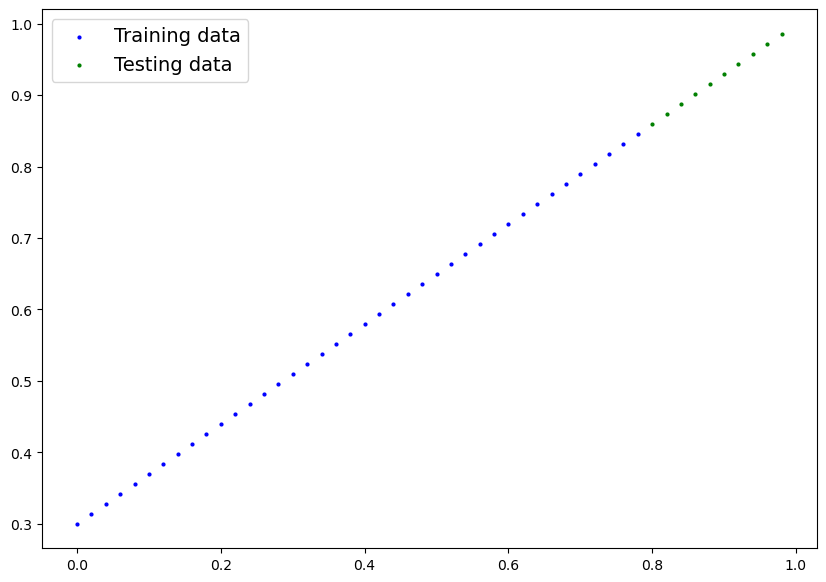

In [4]:

def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions= None):
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size":14})

plot_predictions()

## 2. build model
### PyTorch モデル構築の要点
PyTorch には、想像できるほぼすべての種類のニューラル ネットワークを作成するために使用できる 4 つの (ギブ オア テイク) 重要なモジュールがあります。

それらは、torch.nn、torch.optim、torch.utils.data.Dataset、および torch.utils.data.DataLoader です。ここでは、最初の 2 つに焦点を当て、他の 2 つについては後で説明します (ただし、それらが何をするかは推測できるかもしれません)。


|PyTorch モジュール|	それは何をしますか?|
|-|-|
|torch.nn	|計算グラフのすべての構成要素が含まれます (基本的には、特定の方法で実行される一連の計算)。|
|torch.nn.Parameter	|nn.Module で使用できるテンソルを格納します。requires_grad=True勾配(勾配降下法によるモデルパラメータの更新に使用)が自動的に計算される場合、これはしばしば「自動グラデーション」と呼ばれます。|
|torch.nn.Module	|すべてのニューラルネットワークモジュールの基本クラスであり、ニューラルネットワークのすべてのビルディングブロックはサブクラスです。PyTorch でニューラル ネットワークを構築する場合、モデルは nn.Module をサブクラス化する必要があります。|
|torch.optim	|さまざまな最適化アルゴリズムが含まれています (これらは nn.Parameter に格納されているモデル パラメーターを伝えます。パラメータ 勾配降下法を改善し、ひいては損失を減らすためにどのように変更するのが最適か)。|
|def forward()	|すべてのnn.Moduleのサブクラスにはforward()メソッドが必要であり、これは特定のnnに渡されるデータに対して行われる計算を定義します。モジュール (例: 上記の線形回帰式)。|

In [5]:
# create linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in pytorch inherhits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### PyTorch モデルの内容の確認


In [6]:
# Create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [7]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### torch.inference_mode() を使用して予測を行う
これを確認するために、テストデータX_test渡して、y_testをどれだけ正確に予測するかを確認できます。

モデルにデータを渡すと、モデルの `forward()` メソッドを経由し、定義した計算を使用して結果が生成されます。

いくつかの予測をしてみましょう。

torch.inference_mode()は、その名の通り、推論(予測)にモデルを使用するときに使います。

torch.inference_mode() は、フォワードパス (forward() メソッドを通過するデータ) を高速化するために、多くのもの (グラディエントトラッキングなど、トレーニングには必要ですが、推論には必要ではありません) をオフにします。

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


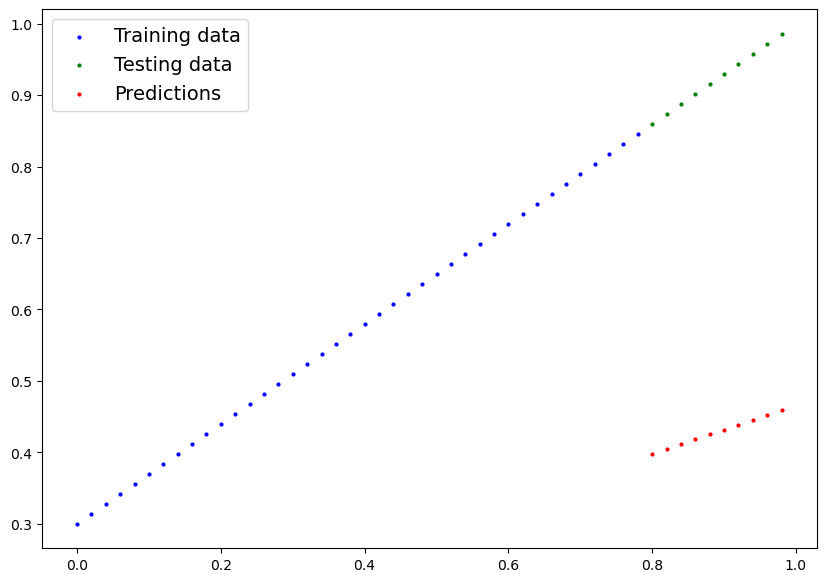

In [8]:
# make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# you can also do something similar with torch.no_grad(),
# however, torch.inference_mode() is preferred
# with torch.no_grad():
#     y_preds = model_0(X_test)

print(y_preds)
print(y_test)
plot_predictions(predictions=y_preds)

## 3. モデルのトレーニング
現在、私たちのモデルはランダムなパラメータを使用して予測を行い、計算を行っていますが、基本的には(ランダムに)推測しています。

これを修正するために、その内部パラメータ(パラメータをパターンとも呼んでいます)、nn.Parameter() と torch.randn()を使用してランダムに設定する重みとバイアス値を更新し、データをより適切に表現するものになります。

### Creating a loss function and optimizer in PyTorch

|Function|	What does it do?	|Where does it live in PyTorch?	|Common values|
|-|-|-|-|
|Loss function|	Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.|	PyTorch has plenty of built-in loss functions in torch.nn.	|回帰問題の平均絶対誤差 (MAE) (torch.nn.L1Loss())二項分類問題に対する二項クロスエントロピー (torch.nn.BCELoss())|
|Optimizer	|Tells your model how to update its internal parameters to best lower the loss.|	You can find various optimization function implementations in torch.optim.	|確率的勾配降下法 (torch.optim.SGD())Adam オプティマイザー (torch.optim.Adam())|

平均絶対誤差 (MAE、PyTorch では torch.nn.L1Loss) は、2 つの点 (予測とラベル) 間の絶対差を測定し、すべての例の平均を取ります。

そして、SGD、torch.optim.SGD(params, lr) を使用します。

* params は、最適化するターゲットモデルのパラメータです (たとえば、以前にランダムに設定した重みとバイアスの値)。
* lr は、オプティマイザーがパラメーターを更新する学習率であり、高いほどオプティマイザーがより大きな更新を試行し (これらが大きすぎてオプティマイザーが機能しない場合があります)、低い場合はオプティマイザーが小さな更新を試行します (これらは小さすぎる場合があり、オプティマイザーが理想的な値を見つけるのに時間がかかりすぎる場合があります)。学習率はハイパーパラメーターと見なされます (機械学習エンジニアによって設定されるため)。学習率の一般的な開始値は 0.01、0.001、0.0001 ですが、これらは時間の経過とともに調整することもできます (これは学習率スケジューリングと呼ばれます)。


In [9]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.005)

### PyTorch での最適化ループの作成
損失関数とオプティマイザができたので、次はトレーニングループ(およびテストループ)を作成します。

トレーニング ループでは、モデルがトレーニング データを調べ、特徴とラベルの関係を学習します。

テストループでは、テストデータを調べ、モデルがトレーニングデータで学習したパターンがどの程度優れているかを評価します(モデルはトレーニング中にテストデータを見ることはありません)。

これらはそれぞれ「ループ」と呼ばれます。これは、モデルが各データセットの各サンプルを検索(ループスルー)するようにするためです。

### PyTorch トレーニング ループ

|数|	ステップ名|	それは何をしますか?|	コード例|
|-|-|-|-|
|1	|フォワードパス	|モデルは、すべてのトレーニング データを 1 回調べて、forward() 関数の計算を実行します。	|model(x_train)|
|2	|損失を計算する	|モデルの出力 (予測) はグラウンド トゥルースと比較され、それらがどの程度間違っているかを確認するために評価されます。	|loss = loss_fn(y_pred, y_train)|
|3	|勾配ゼロ	|オプティマイザーの勾配はゼロに設定されているため (デフォルトでは累積されます)、特定のトレーニングステップで再計算できます。	|optimizer.zero_grad()|
|4	|損失に対してバックプロパゲーションを実行する	|更新するすべてのモデル パラメーター (requires_grad=True の各パラメーター) を基準にして、損失の勾配を計算します。これはバックプロパゲーションと呼ばれ、したがって「バックワード」と呼ばれます。	|loss.backward()|
|5	|オプティマイザーを更新する (勾配降下法)	|損失勾配を改善するために、損失勾配に関してパラメータをrequires_grad=Trueで更新します。	|optimizer.step()|

In [10]:
# An epochs is one loop through the data ...

epochs = 500
# Track different
epoch_count = []
loss_values = []
test_loss_values = []
# 0. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # print(f"loss: {loss}")

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation on the loss with respect to the parameter of the model
    loss.backward()

    # 5. Step the optimizer(perfom gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. do the forward pass
        test_pred = model_0(X_test)
        # 2.calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    # print out what's happening
    if epoch % 50 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.4878006875514984
OrderedDict({'weights': tensor([0.3386]), 'bias': tensor([0.1338])})
Epoch: 50 | Loss: 0.06430868804454803 | Test loss: 0.1780700981616974
OrderedDict({'weights': tensor([0.4344]), 'bias': tensor([0.3583])})
Epoch: 100 | Loss: 0.04165184870362282 | Test loss: 0.10024197399616241
OrderedDict({'weights': tensor([0.4929]), 'bias': tensor([0.3841])})
Epoch: 150 | Loss: 0.03300347179174423 | Test loss: 0.07681445777416229
OrderedDict({'weights': tensor([0.5367]), 'bias': tensor([0.3686])})
Epoch: 200 | Loss: 0.024415846914052963 | Test loss: 0.05682113766670227
OrderedDict({'weights': tensor([0.5793]), 'bias': tensor([0.3506])})
Epoch: 250 | Loss: 0.01582920178771019 | Test loss: 0.03648443892598152
OrderedDict({'weights': tensor([0.6221]), 'bias': tensor([0.3328])})
Epoch: 300 | Loss: 0.007245112210512161 | Test loss: 0.0164911150932312
OrderedDict({'weights': tensor([0.6648]), 'bias': tensor([0.3148])})
Epoch: 350 | Loss

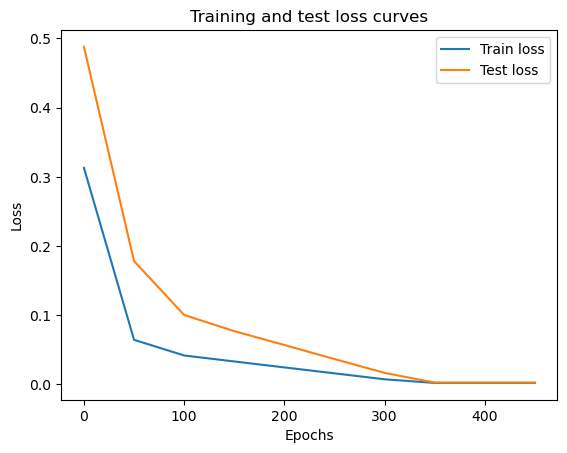

In [11]:
import numpy as np
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


## 4. トレーニング済みのPyTorchモデルによる予測(推論)
PyTorch モデルを使用して予測 (推論の実行とも呼ばれます) を行う際には、次の 3 つの点に注意してください。

* モデルを評価モード(model.eval())に設定します。
* 推論モードのコンテキストマネージャー () を使用して予測を行います with torch.inference_mode(): ... 。
* すべての予測は、同じデバイス上のオブジェクトを使用して行う必要があります (例: データとモデルが GPU のみ、データとモデルが CPU のみ)。

0.7 0.3
tensor([[0.8561],
        [0.8701],
        [0.8840],
        [0.8979],
        [0.9118],
        [0.9257],
        [0.9396],
        [0.9535],
        [0.9674],
        [0.9813]])
OrderedDict({'weights': tensor([0.6954]), 'bias': tensor([0.2998])})


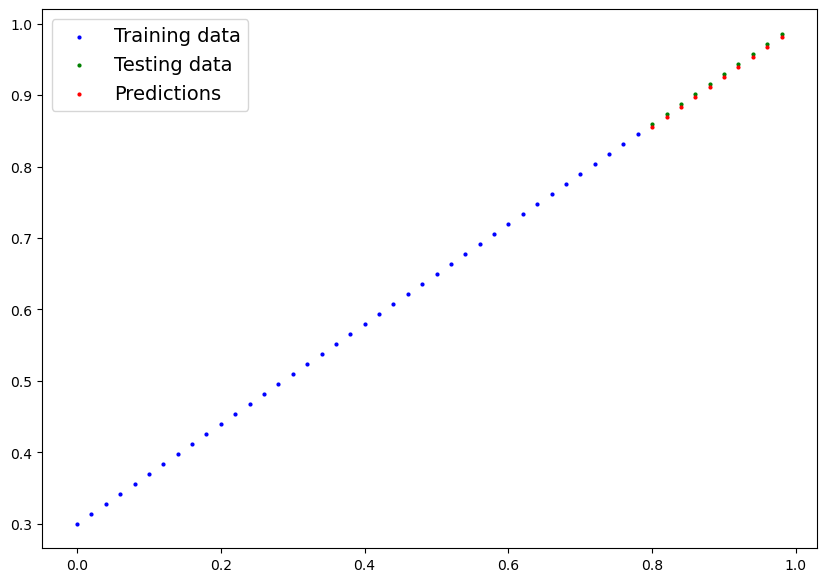

In [12]:
print(weight, bias)
model_0.eval()
with torch.inference_mode():
    y_pred_new = model_0(X_test)
    print(y_pred_new)
    print(model_0.state_dict())
plot_predictions(predictions=y_pred_new)

## 5.Saving and loading a PyTorch model
|PyTorch メソッド	|それは何をしますか?|
|-|-|
|torch.save	|Python の pickle ユーティリティを使用して、シリアル化されたオブジェクトをディスクに保存します。モデル、テンソル、および辞書などの他のさまざまなPythonオブジェクトは、torch.saveを使用して保存できます。|
|torch.load	|pickle の unpickle 機能を使用して、pickle 化された Python オブジェクト ファイル (モデル、テンソル、辞書など) を逆シリアル化してメモリに読み込みます。オブジェクトをロードするデバイス(CPU、GPUなど)を設定することもできます。|
|torch.nn.Module.load_state_dict	|保存された state_dict() オブジェクトを使用して、モデルのパラメータディクショナリ (model.state_dict()) を読み込みます。|

### PyTorch モデルの state_dict() の保存
推論のためにモデルを保存して読み込む (予測を行う) ための推奨される方法は、モデルの state_dict() を保存して読み込むことです。

いくつかの手順でそれを行う方法を見てみましょう。

* Pythonのpathlibモジュールを使用して、呼び出されたモデルにモデルを保存するためのディレクトリを作成します。
* モデルを保存するためのファイルパスを作成します。
* torch.save(obj, f) を呼び出します。ここで、obj はターゲットモデルの state_dict() で、f はモデルを保存するファイル名です。

In [13]:
# Saving our pytorch model
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH) 

# 3. save the model state dict
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

models/01_pytorch_workflow_model_0.pth
saving model to: models/01_pytorch_workflow_model_0.pth


### 保存したPyTorchモデルのstate_dict()をロードする


In [14]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [15]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6954])), ('bias', tensor([0.2998]))])

In [16]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

# compare loaded model preds with original model preds
loaded_model_preds == y_pred_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. まとめ

Using device: mps
Epoch:0 | Loss: 0.5551779270172119 | Test loss: 0.5739762783050537
Epoch:10 | Loss: 0.4399681091308594 | Test loss: 0.4392664134502411
Epoch:20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch:30 | Loss: 0.20954833924770355 | Test loss: 0.16984672844409943
Epoch:40 | Loss: 0.09433844685554504 | Test loss: 0.03513688966631889
Epoch:50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch:60 | Loss: 0.019956793636083603 | Test loss: 0.04580312967300415
Epoch:70 | Loss: 0.016517985612154007 | Test loss: 0.037530578672885895
Epoch:80 | Loss: 0.013089167885482311 | Test loss: 0.02994491532444954
Epoch:90 | Loss: 0.009653175249695778 | Test loss: 0.02167237363755703
Epoch:100 | Loss: 0.006215682718902826 | Test loss: 0.014086711220443249
Epoch:110 | Loss: 0.002787243574857712 | Test loss: 0.005814170930534601
Epoch:120 | Loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch:130 | Loss: 0.0012645088136196136 | Test loss: 0.0138018

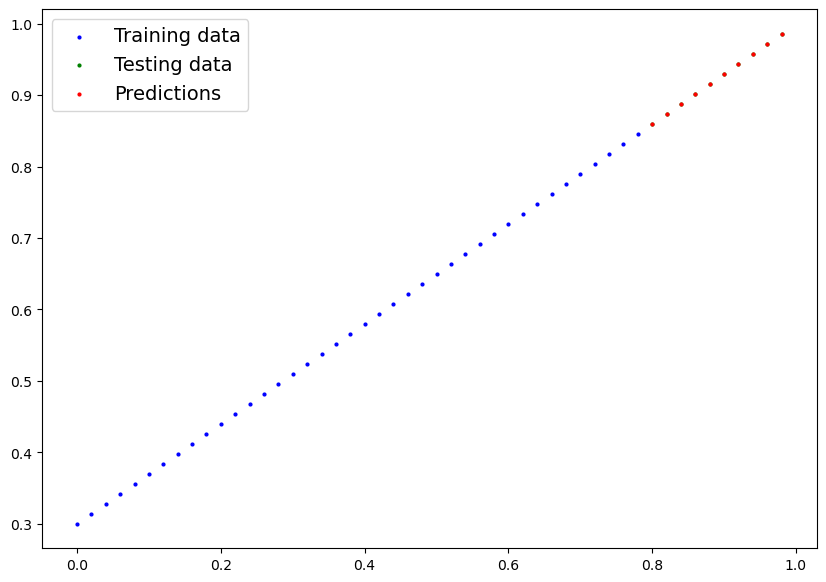

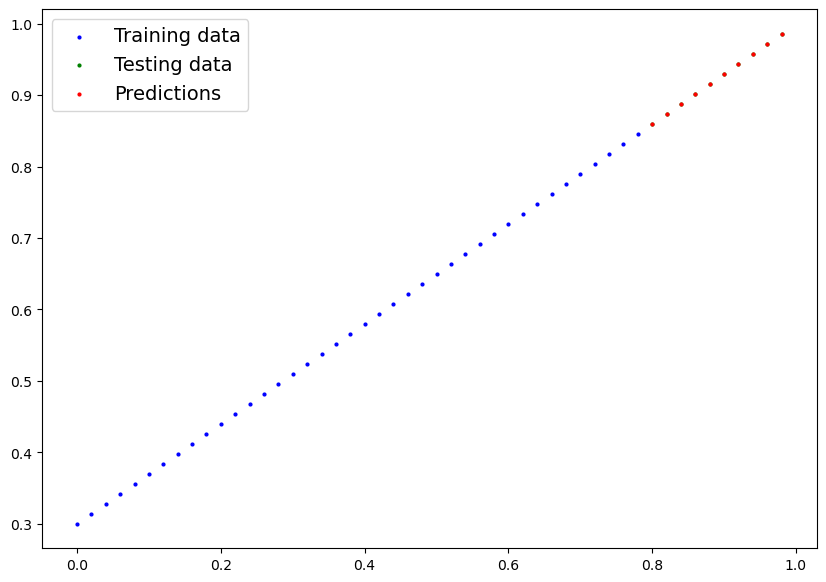

In [17]:
# import pytorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

torch.__version__
# Setup device agnostic code
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

# create some data using the linear regression formula
weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# create X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
X.shape
y = weight * X + bias

# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
#len(X_train),len(y_train),len(X_test),len(y_test)

# plot the data
# plot_predictions(X_train, y_train, X_test, y_test)

# building a pytorch linear model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # use nn.Linear() for createing the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()

# set the model to use the target device
model_1.to(device=device)
next(model_1.parameters()).device

# setup the loss function
loss_fn = nn.L1Loss()

# setup the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

# let's write a training loop
torch.manual_seed(42)

epochs = 200

# put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    model_1.train()
    # forward pass
    y_pred = model_1(X_train)
    # calculate the loss
    loss = loss_fn(y_pred, y_train)
    # optimizer zero grad
    optimizer.zero_grad()
    # perform backpropagation
    loss.backward()
    # optimizer step
    optimizer.step()

    # testing
    model_1.eval()
    
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    # print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch:{epoch} | Loss: {loss} | Test loss: {test_loss}")

print(model_1.state_dict())

# turn model into evaluation mode
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

# save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

# load model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device=device)

# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds==loaded_model_1_preds
plot_predictions(predictions=loaded_model_1_preds.cpu())


## note:ニューラルネットワークにおける導関数の役割

ニューラルネットワークの学習の主な目標は、損失関数を最小化することです。

損失関数は、ネットワークの予測と実際の正解との間の誤差を測る指標となります。

この損失関数を最小化するために、ネットワークのパラメータである重み（とバイアス）を調整する必要があります。

ここで重要な役割を果たすのが導関数です。損失関数を各重みで微分することで得られる偏導関数（勾配）は、

その重みをわずかに変化させたときに損失関数がどのように変化するかを示します。

具体的には、勾配の方向は損失関数が最も増加する方向を指し示すため、学習においては勾配の反対方向に重みを更新することで、損失関数を徐々に小さくしていきます。

この勾配を効率的に計算するために用いられるのが、バックプロパゲーション（誤差逆伝播法）です。

バックプロパゲーションは、微分の連鎖律を利用して、出力層から入力層に向かって順に勾配を計算していくアルゴリズムです。

### 重み (w) の変化に伴う平均二乗誤差 (MSE) の導関数の変化
線形関数 y=wx+b における平均二乗誤差損失関数 L(w)=((wx+b)−t) ** 2を例に考えると、この損失関数を重み w で微分した導関数は`​f'(w)=2x(wx+b−t)`となります。

この導関数の変化を分析すると、以下の点がわかります。

線形な変化: 導関数  
* `​f'(w)`は、w に対して線形な関数です。つまり、w が一定の割合で変化すると、導関数も一定の割合で変化します。

符号の意味:
* `​f'(w)>0` の場合、重み w を増加させると損失関数が増加するため、w を減少させるべきです。
* `​f'(w)<0` の場合、重み w を増加させると損失関数が減少するため、w を増加させるべきです。
* `f'(w)=0` の場合、現在の w の値は損失関数を局所的に最小にする点である可能性があります。

大きさの意味: 導関数の絶対値が大きいほど、現在の重みのわずかな変化が損失関数に大きな影響を与えることを意味します。

したがって、重みを大きく調整する必要があります。


グラフで可視化すると、MSE 損失関数は w に対して下に凸の放物線を描き、

その導関数は w に対して傾きを持つ直線となります。

MSE 損失関数が最小値を取る点（放物線の底）では、導関数の値は 0 となります。

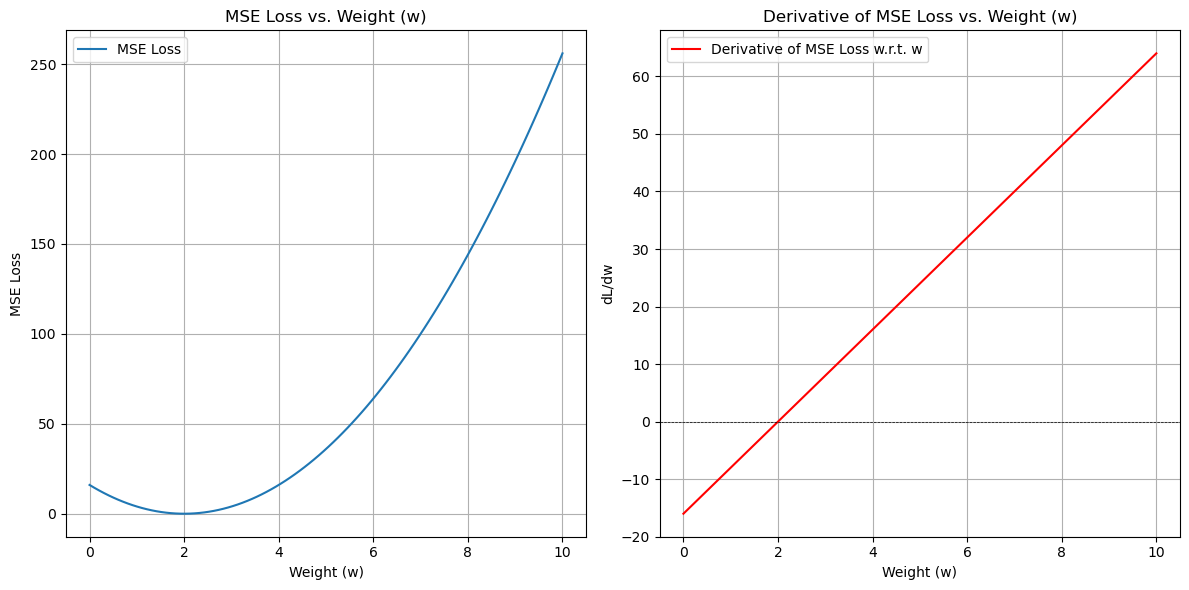

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 固定x, t, b
x_data = 2
true_target = 5
bias = 1

# wの範囲
w_values = np.linspace(0, 10, 100)

#  MSE loss function
mse_loss_values = ((w_values * x_data + bias) - true_target)**2

# f'(w)
derivative_values = 2 * x_data * (w_values * x_data + bias - true_target)

plt.figure(figsize=(12, 6))

# MSE Loss
plt.subplot(1, 2, 1)
plt.plot(w_values, mse_loss_values, label='MSE Loss')
plt.xlabel('Weight (w)')
plt.ylabel('MSE Loss')
plt.title('MSE Loss vs. Weight (w)')
plt.grid(True)
plt.legend()

# f'(x)
plt.subplot(1, 2, 2)
plt.plot(w_values, derivative_values, label='Derivative of MSE Loss w.r.t. w', color='red')
plt.xlabel('Weight (w)')
plt.ylabel('dL/dw')
plt.title('Derivative of MSE Loss vs. Weight (w)')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()